# Brain Tumor MRI Image Segmentation

ValueError: Unknown metric function: dice_coef

### Setting up env

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install seaborn
!pip install scikit-image

In [3]:
!pip install nilearn
!pip install nibabel
!pip install -U scikit-learn

In [6]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# To analyse MRI scans
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing



np.set_printoptions(precision=3, suppress=True)

C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\nilearn\__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


### Defining the Segment Areas

In [8]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

### Dataset

Text(0.5, 1.0, 'Ground Truth')

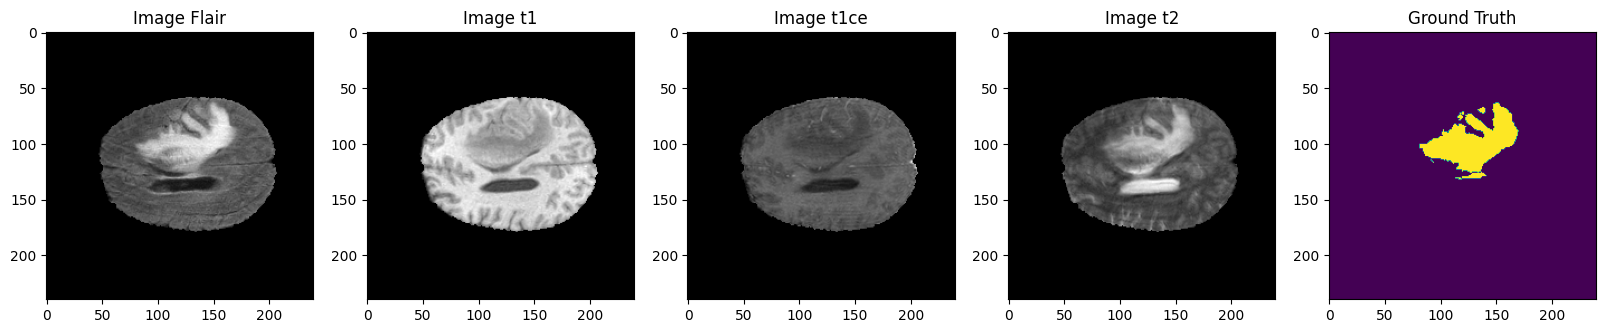

In [9]:
path_training = './brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
path_validation = './brats/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(path_training + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(path_training + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(path_training + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(path_training + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_groundtruth=nib.load(path_training + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image Flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_groundtruth[:,:,test_groundtruth.shape[0]//2-slice_w])
ax5.set_title('Ground Truth')


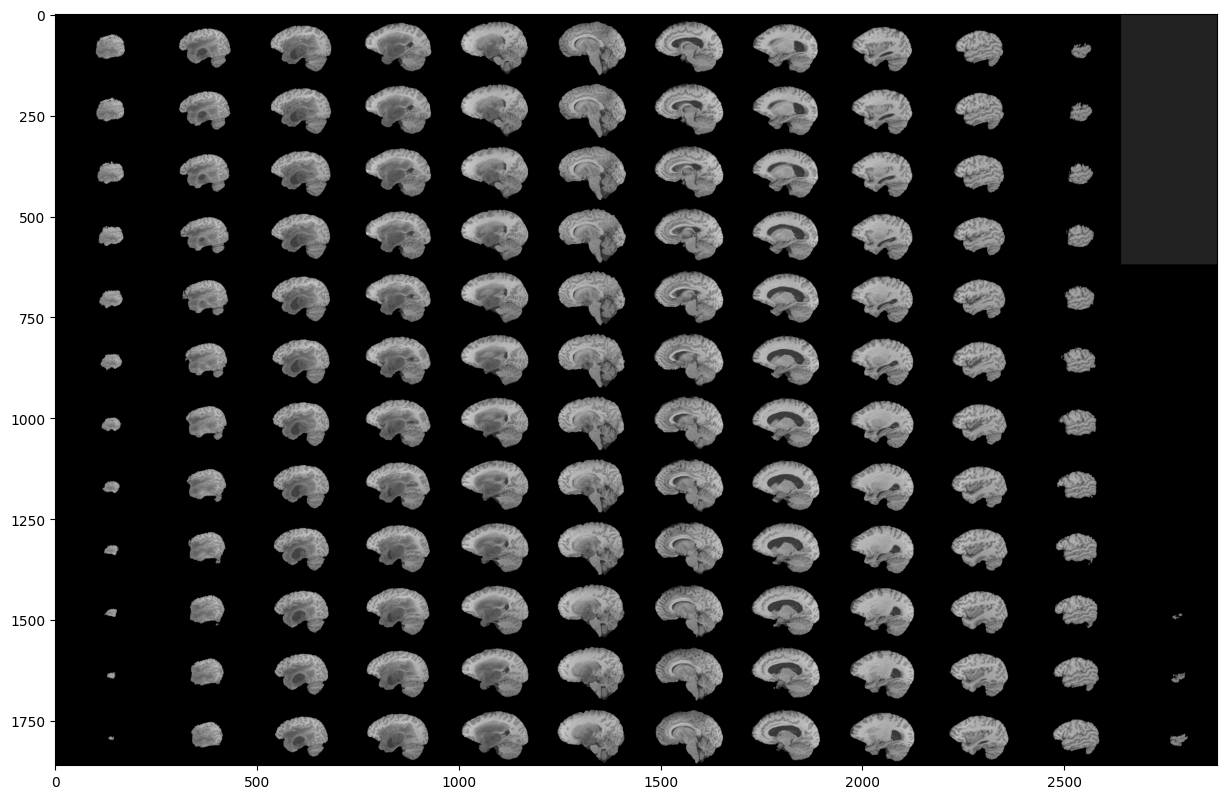

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

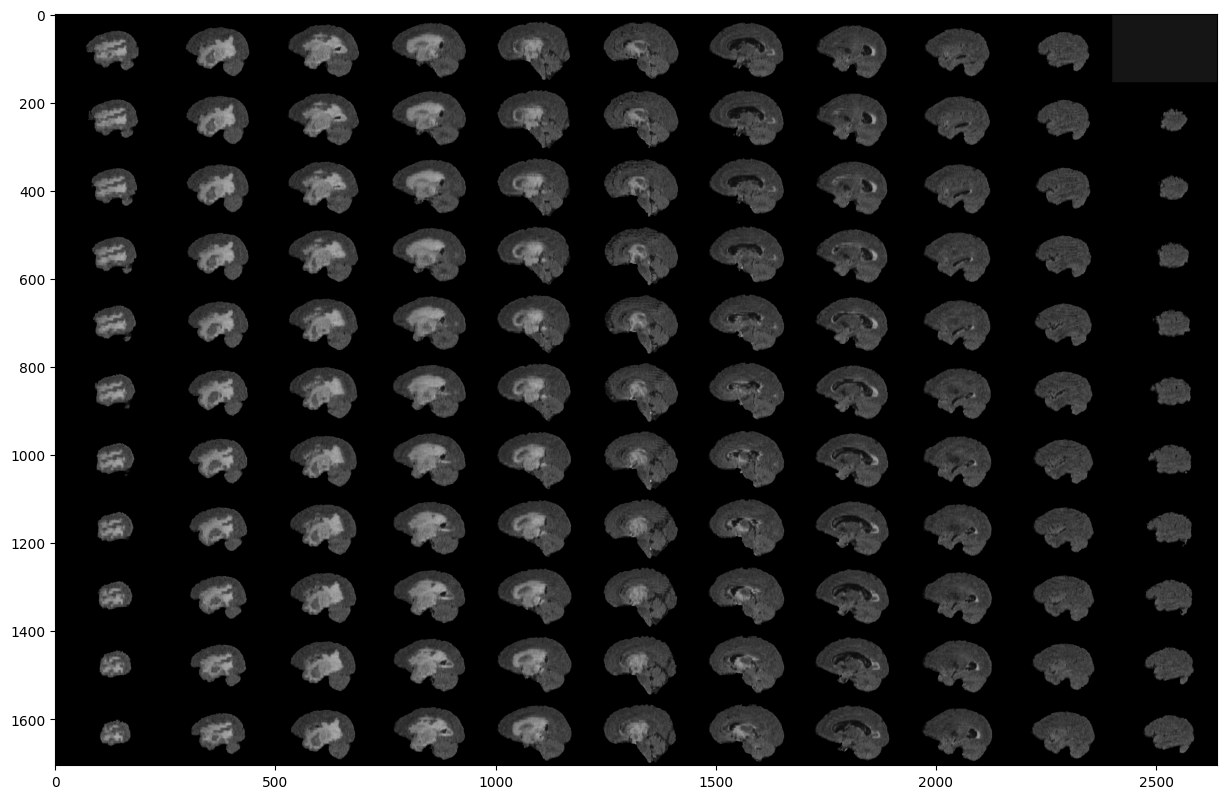

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_flair[60:-60,:,:]), 90, resize=True), cmap ='gray')

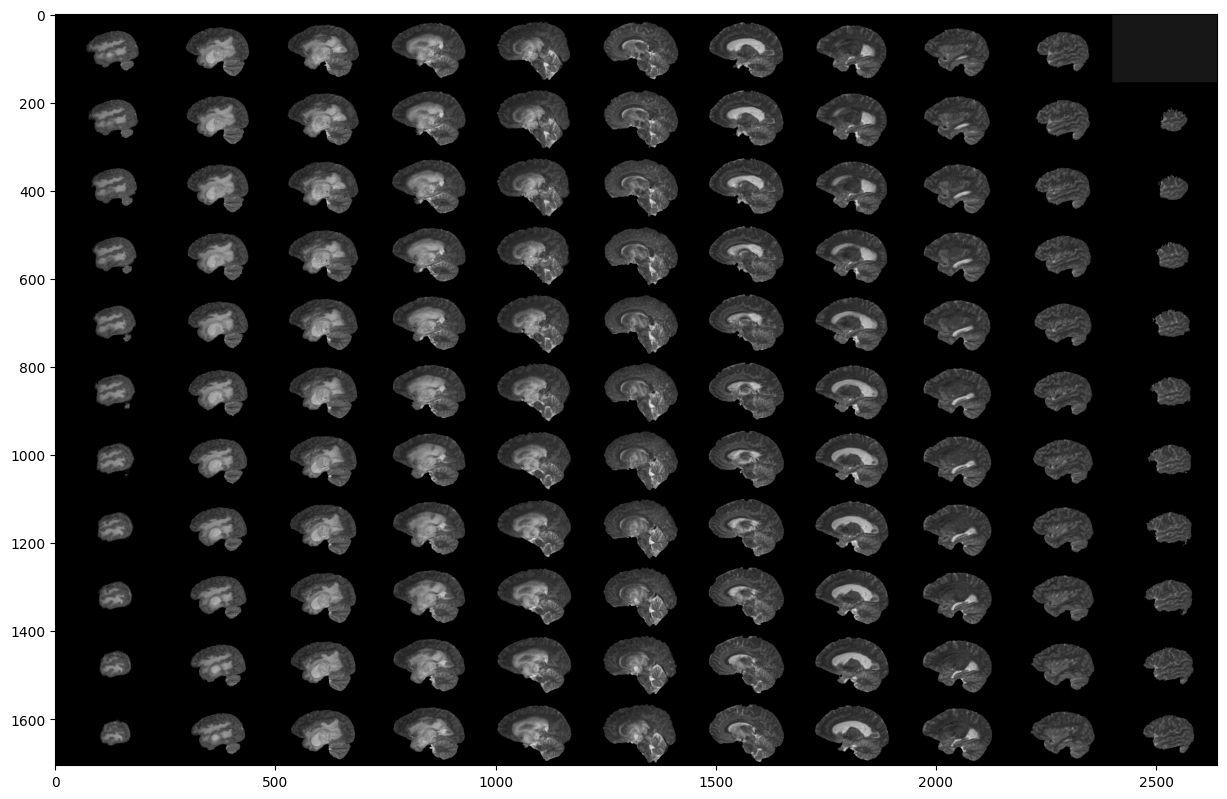

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t2[60:-60,:,:]), 90, resize=True), cmap ='gray')

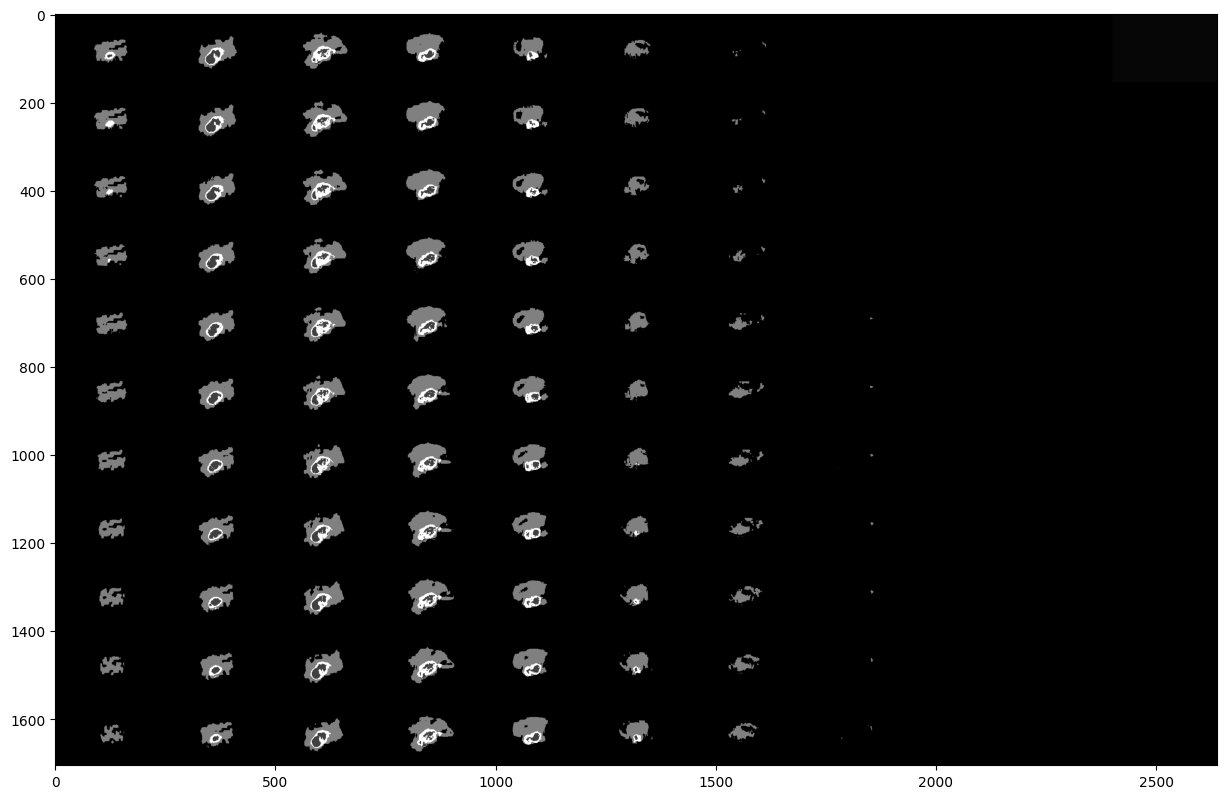

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_groundtruth[60:-60,:,:]), 90, resize=True), cmap ='gray')

### Perspective planes used in medical imaging

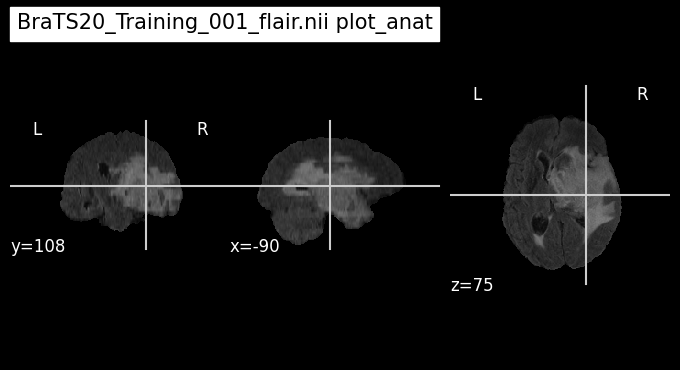

In [11]:
img = nl.image.load_img(path_training + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
gndt = nl.image.load_img(path_training + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')


nlplt.plot_anat(img,
                title='BraTS20_Training_001_flair.nii plot_anat')

##### 1. Axial

Text(0.5, 1.0, 'Ground Truth')

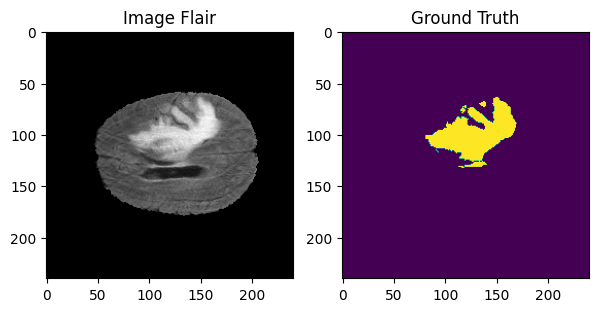

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (7, 3.5))

ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image Flair')

ax2.imshow(test_groundtruth[:,:,test_groundtruth.shape[0]//2-slice_w])
ax2.set_title('Ground Truth')

##### 2. Coronal 

Text(0.5, 1.0, 'Ground Truth')

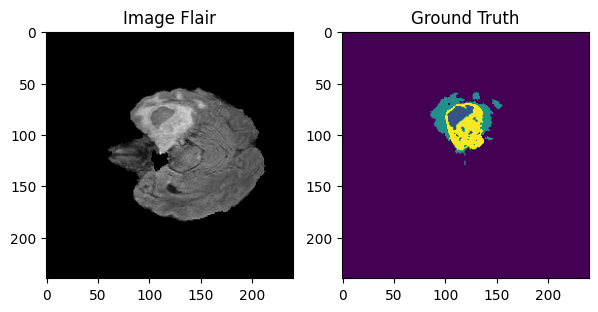

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (7, 3.5))

ax1.imshow(test_image_flair[:,:,test_image_flair.shape[2]//2-slice_w], cmap = 'gray')
ax1.set_title('Image Flair')

ax2.imshow(test_groundtruth[:,:,test_groundtruth.shape[2]//2-slice_w])
ax2.set_title('Ground Truth')

##### 3. Sagittal

#### Dice Similarity Coefficient

In [10]:
def dice_coef(y_true, y_pred, smooth=1):
    class_num = 4
    total_loss = 0.0

    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.flatten(y_pred[:, :, :, i])

        intersection = K.sum(y_true_f * y_pred_f)
        current_loss = (2. * intersection +  smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) +  smooth)

        total_loss = current_loss if i == 0 else total_loss + current_loss

    total_loss /= class_num
    return total_loss
    
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

# precision calculation
def precision(y_true, y_pred):
    epsilon = K.epsilon()
    return K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + epsilon)
    
# sensitivity calculation
def sensitivity(y_true, y_pred):
    epsilon = K.epsilon() 
    return K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_true, 0, 1))) + epsilon)
    

# Specificity calculation
def specificity(y_true, y_pred):
    epsilon = K.epsilon() 
    return K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1))) / (K.sum(K.round(K.clip(1-y_true, 0, 1))) +epsilon)




In [11]:
IMG_SIZE=128

In [12]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(conv)
    return conv

def upsample_block(inputs, skip_connections, filters, kernel_size=2, activation='relu', padding='same', kernel_initializer='he_normal'):
    upsample = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(UpSampling2D(size=(2, 2))(inputs))
    merge = concatenate([skip_connections, upsample], axis=3)
    conv = conv_block(merge, filters)
    return conv

def build_unet(inputs, num_classes=4, kernel_initializer='he_normal', dropout=0.2):
    conv1 = conv_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv_block(pool4, 512)
    drop5 = Dropout(dropout)(conv5)

    up6 = upsample_block(drop5, conv4, 256)
    up7 = upsample_block(up6, conv3, 128)
    up8 = upsample_block(up7, conv2, 64)
    up9 = upsample_block(up8, conv1, 32)

    conv10 = Conv2D(num_classes, (1, 1), activation='softmax')(up9)

    return Model(inputs=inputs, outputs=conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
model = build_unet(input_layer)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)


In [17]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [15]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

TypeError: plot_model() got an unexpected keyword argument 'show_dtype'

In [16]:
# List directories with studies
train_and_val_directories = [f.path for f in os.scandir(path_training) if f.is_dir()]

# Remove the directory with an ill-formatted name
ill_formatted_dir = os.path.join(path_training, 'BraTS20_Training_355')
train_and_val_directories = [dir_path for dir_path in train_and_val_directories if dir_path != ill_formatted_dir]

# Extract study IDs from paths
def pathListIntoIds(dir_list):
    # Extract the study ID from the directory path
    return [os.path.basename(dir_path) for dir_path in dir_list]

train_and_test_ids = pathListIntoIds(train_and_val_directories)

# Split the study IDs into training, validation, and test sets
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

# Print the resulting sets of study IDs
print("Training Study IDs:", train_ids)
print("Validation Study IDs:", val_ids)
print("Test Study IDs:", test_ids)

Training Study IDs: ['BraTS20_Training_294', 'BraTS20_Training_100', 'BraTS20_Training_260', 'BraTS20_Training_067', 'BraTS20_Training_285', 'BraTS20_Training_250', 'BraTS20_Training_201', 'BraTS20_Training_132', 'BraTS20_Training_267', 'BraTS20_Training_309', 'BraTS20_Training_191', 'BraTS20_Training_181', 'BraTS20_Training_004', 'BraTS20_Training_118', 'BraTS20_Training_338', 'BraTS20_Training_205', 'BraTS20_Training_099', 'BraTS20_Training_318', 'BraTS20_Training_145', 'BraTS20_Training_105', 'BraTS20_Training_030', 'BraTS20_Training_196', 'BraTS20_Training_239', 'BraTS20_Training_116', 'BraTS20_Training_315', 'BraTS20_Training_016', 'BraTS20_Training_339', 'BraTS20_Training_036', 'BraTS20_Training_134', 'BraTS20_Training_089', 'BraTS20_Training_347', 'BraTS20_Training_269', 'BraTS20_Training_090', 'BraTS20_Training_348', 'BraTS20_Training_255', 'BraTS20_Training_241', 'BraTS20_Training_077', 'BraTS20_Training_328', 'BraTS20_Training_005', 'BraTS20_Training_117', 'BraTS20_Training_2

In [17]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        batch_IDs = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(batch_IDs)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_IDs):
        X, y = self._initialize_data_arrays()

        for c, study_ID in enumerate(batch_IDs):
            case_path = os.path.join(path_training, study_ID)

            flair = self._load_data(case_path, f'{study_ID}_flair.nii')
            ce = self._load_data(case_path, f'{study_ID}_t1ce.nii')
            seg = self._load_data(case_path, f'{study_ID}_seg.nii')

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = self._resize_data(flair[:, :, j + VOLUME_START_AT])
                X[j + VOLUME_SLICES * c, :, :, 1] = self._resize_data(ce[:, :, j + VOLUME_START_AT])
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        y = self._process_labels(y)
        return X / np.max(X), y

    def _initialize_data_arrays(self):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        return X, y

    def _load_data(self, case_path, file_name):
        data_path = os.path.join(case_path, file_name)
        return nib.load(data_path).get_fdata()

    def _resize_data(self, data_slice):
        return cv2.resize(data_slice, (IMG_SIZE, IMG_SIZE))

    def _process_labels(self, labels):
        labels[labels == 4] = 3
        mask = tf.one_hot(labels, 4)
        return tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))


training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


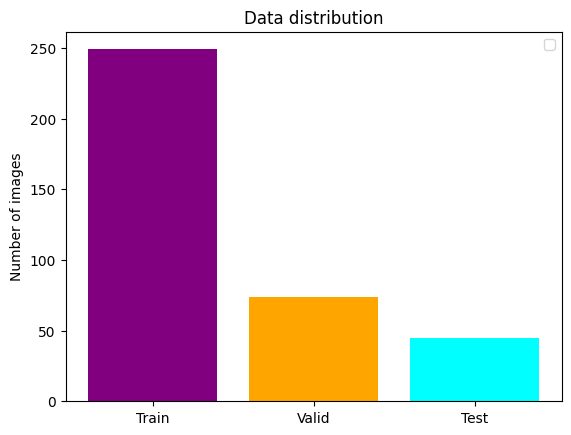

In [21]:
def DataLayout(train_ids, val_ids, test_ids):
    data_splits = ["Train", "Valid", "Test"]
    data_lengths = [len(train_ids), len(val_ids), len(test_ids)]
    colors = ['purple', 'orange', 'cyan']


    plt.bar(data_splits, data_lengths, align='center', color=colors)
    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.legend()

    plt.show()

DataLayout(train_ids, val_ids, test_ids)


In [22]:
csv_logger = CSVLogger('training.log', separator=',', append=False)

callbacks = [
    keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                                  patience=2, verbose=1, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=2, min_lr=0.000001, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath='model_.{epoch:02d}-{val_loss:.6f}.m5',
                                    verbose=1, save_best_only=True, save_weights_only=True),
    csv_logger
]


In [23]:
history =  model.fit(training_generator,
                     epochs=6,
                     steps_per_epoch=len(train_ids),
                     validation_data = valid_generator,
                     callbacks=callbacks,
                     )  
model.save("model.h5")

Epoch 1/6
249/249 [==============================] - ETA: 0s - loss: 0.2790 - accuracy: 0.9792 - mean_io_u: 0.9734 - dice_coef: 0.2670 - precision: 0.9829 - sensitivity: 0.9766 - specificity: 0.9944 - dice_coef_necrotic: 8.1552e-05 - dice_coef_edema: 4.0333e-04 - dice_coef_enhancing: 2.3317e-04 
Epoch 00001: val_loss improved from inf to 0.26310, saving model to model_.01-0.263098.m5
249/249 [==============================] - 6133s 25s/step - loss: 0.2790 - accuracy: 0.9792 - mean_io_u: 0.9734 - dice_coef: 0.2670 - precision: 0.9829 - sensitivity: 0.9766 - specificity: 0.9944 - dice_coef_necrotic: 8.1552e-05 - dice_coef_edema: 4.0333e-04 - dice_coef_enhancing: 2.3317e-04 - val_loss: 0.2631 - val_accuracy: 0.9837 - val_mean_io_u: 0.9795 - val_dice_coef: 0.2760 - val_precision: 0.9837 - val_sensitivity: 0.9837 - val_specificity: 0.9946 - val_dice_coef_necrotic: 0.0000e+00 - val_dice_coef_edema: 0.0000e+00 - val_dice_coef_enhancing: 0.0000e+00
Epoch 2/6
249/249 [==========================

In [18]:
# model = keras.models.load_model('./model.h5')
model = keras.models.load_model('./model.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

In [26]:
############ load trained model ################
# model = keras.models.load_model('../input/modelperclasseval/model_per_class.h5', 
#                                    custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
#                                                    "dice_coef": dice_coef,
#                                                    "precision": precision,
#                                                    "sensitivity":sensitivity,
#                                                    "specificity":specificity,
#                                                               "dice_coef_necrotic": dice_coef_necrotic,
#                                                    "dice_coef_edema": dice_coef_edema,
#                                                    "dice_coef_enhancing": dice_coef_enhancing
#                                                   }, compile=False)

history = pd.read_csv('./training.log', sep=',', engine='python')

hist=history


In [27]:
acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

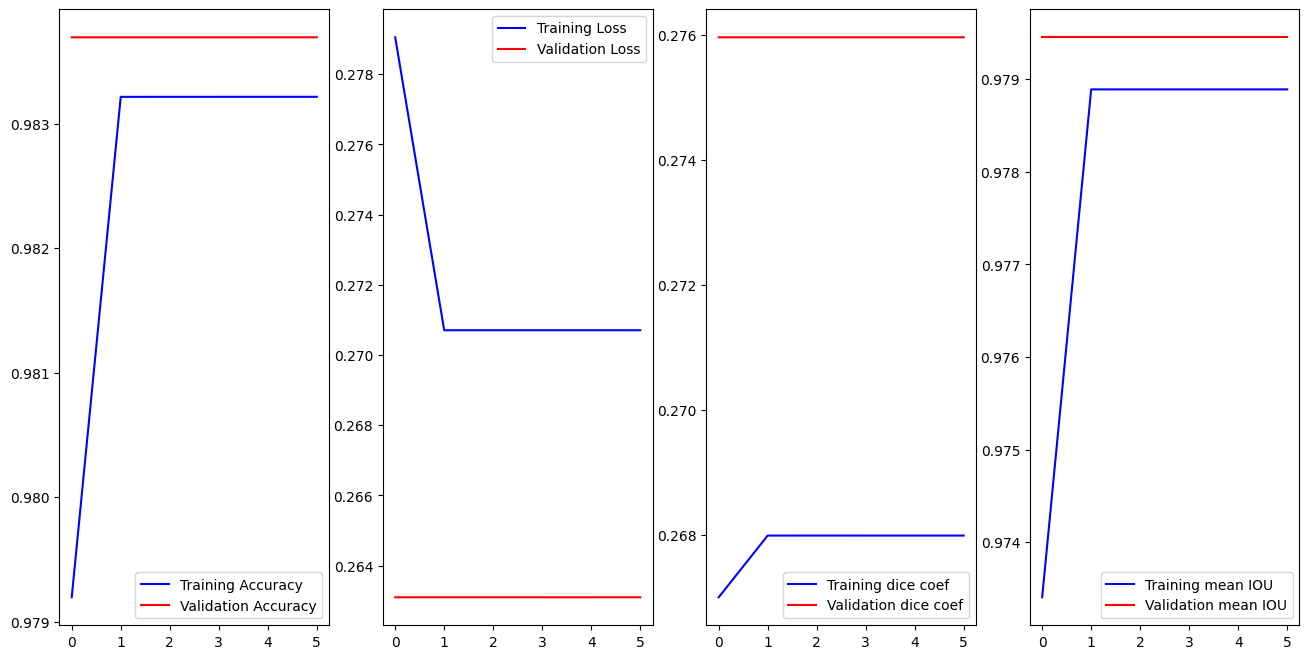

In [28]:
f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [20]:
model = keras.models.load_model('./model.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

In [21]:
tf.saved_model.save(model, 'saved_model')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model\assets


In [23]:
# Get the model architecture in JSON format
model_json = model.to_json()

# Save the model architecture to a JSON file
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

# Save the model weights to a separate file
model.save_weights('model_weights.h5')


In [25]:
import numpy as np

# Get the weights of the model
weights = model.get_weights()

# Save the weights to a binary file
with open('model_weights.bin', 'wb') as f:
    for w in weights:
        np.array(w).astype(np.float32).tofile(f)


In [33]:
nifti_file_path = path_training + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii'
nifti_image = nib.load(nifti_file_path)

# Get the image data from the NIfTI file
nifti_data = nifti_image.get_fdata()

In [35]:
desired_size = (128, 128)
resized_image = cv2.resize(nifti_data, desired_size)

# Add an extra dimension to match the expected shape
resized_image = np.expand_dims(resized_image, axis=-1)

In [38]:
print(resized_image.shape)

(128, 128, 155, 1)


In [36]:
predicted_output = model.predict(np.expand_dims(resized_image, axis=0))


ValueError: in user code:

    C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer conv2d is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape [None, None, None, 155]


In [1]:
pip install h5py

DEPRECATION: Loading egg at c:\users\lavan\appdata\local\programs\python\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import h5py
import json

def hdf5_to_json(hdf5_file, json_file):
    with h5py.File(hdf5_file, 'r') as hf:
        data = {}
        for key in hf.keys():
            data[key] = hf[key][()]
    with open(json_file, 'w') as jf:
        json.dump(data, jf)

# Replace 'input.hdf5' and 'output.json' with your file names
hdf5_to_json('best_model.hdf5', 'output.json')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_model.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)